# Obtain the SELU parameters for arbitrary fixed points

*Author:* Guenter Klambauer, 2017


In [1048]:
import numpy as np
from scipy.special import erf,erfc
from sympy import Symbol, solve, nsolve

### Function to obtain the parameters for the SELU with arbitrary fixed point (mean variance)

In [1049]:
def getSeluParameters(fixedpointMean=0,fixedpointVar=1):
    """ Finding the parameters of the SELU activation function. The function returns alpha and lambda for the desired fixed point. """
    
    import sympy
    from sympy import Symbol, solve, nsolve

    aa = Symbol('aa')
    ll = Symbol('ll')
    nu = fixedpointMean 
    tau = fixedpointVar 

    mean =  0.5*ll*(nu + np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi)*np.sqrt(tau) + \
                        nu*erf(nu/(np.sqrt(2*tau))) - aa*erfc(nu/(np.sqrt(2*tau))) + \
                        np.exp(nu+tau/2)*aa*erfc((nu+tau)/(np.sqrt(2*tau))))

    var = 0.5*ll**2*(np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi*tau)*nu + (nu**2+tau)* \
                          (1+erf(nu/(np.sqrt(2*tau)))) + aa**2 *erfc(nu/(np.sqrt(2*tau))) \
                          - aa**2 * 2 *np.exp(nu+tau/2)*erfc((nu+tau)/(np.sqrt(2*tau)))+ \
                          aa**2*np.exp(2*(nu+tau))*erfc((nu+2*tau)/(np.sqrt(2*tau))) ) - mean**2

    eq1 = mean - nu
    eq2 = var - tau

    res = nsolve( (eq2, eq1), (aa,ll), (1.67,1.05))
    return float(res[0]),float(res[1])


In [1073]:
### To recover the parameters of the SELU with mean zero and unit variance
getSeluParameters(0,1)

(1.6732632423543778, 1.0507009873554805)

In [1051]:
### To obtain new parameters for mean zero and variance 2
myFixedPointMean = 0
myFixedPointVar = 2.0
myAlpha, myLambda = getSeluParameters(myFixedPointMean,myFixedPointVar)
getSeluParameters(myFixedPointMean,myFixedPointVar)

(1.9712557503462698, 1.060709076103012)

### Adjust the SELU function and Dropout to your new parameters

In [1052]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = myAlpha
        scale = myLambda
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [1064]:
def relu(x):
    return tf.nn.relu(x)

In [1053]:
import numbers

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops

In [1054]:
def dropout_selu(x, rate, alpha= -myAlpha*myLambda, fixedPointMean=myFixedPointMean, fixedPointVar=myFixedPointVar, 
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)


        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
        
        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))


In [1055]:
import tensorflow as tf
import numpy as np

x = tf.Variable(tf.random.normal([1000], mean=myFixedPointMean, stddev=np.sqrt(myFixedPointVar)))
w = selu(x)
y = dropout_selu(w, 0.2,training=True)

print("mean/var should be at:", myFixedPointMean, "/", myFixedPointVar)
print("Input data mean/var:  ", "{:.12f}".format(np.mean(x.numpy())), "/", "{:.12f}".format(np.var(x.numpy())))    
print("After selu:           ", "{:.12f}".format(np.mean(w.numpy())), "/", "{:.12f}".format(np.var(w.numpy())))
print("After dropout mean/var", "{:.12f}".format(np.mean(y.numpy())), "/", "{:.12f}".format(np.var(y.numpy())))


mean/var should be at: 0 / 2.0
Input data mean/var:   0.009808769450 / 1.946823477745
After selu:            0.007029638160 / 1.941049575806
After dropout mean/var -0.005028413609 / 1.987781286240


In [1070]:
after_selu = []
after_selu_v = []
after_dropout = []
after_dropout_v = []
for i in range(10000):
    z=y
    w = selu(z)
    after_selu.append(np.mean(w.numpy()))
    after_selu_v.append(np.var(w.numpy()))
    y = dropout_selu(w, 0.2,training=True)
    after_dropout.append(np.mean(y.numpy()))
    after_dropout_v.append(np.var(y.numpy()))

print("mean/var should be at:", myFixedPointMean, "/", myFixedPointVar)
print("Input data mean/var:  ", "{:.12f}".format(np.mean(x.numpy())), "/", "{:.12f}".format(np.var(x.numpy())))    
print("After selu:           ", "{:.12f}".format(np.mean(w.numpy())), "/", "{:.12f}".format(np.var(w.numpy())))
print("After dropout mean/var", "{:.12f}".format(np.mean(y.numpy())), "/", "{:.12f}".format(np.var(y.numpy())))

mean/var should be at: 0 / 2.0
Input data mean/var:   0.009808769450 / 1.946823477745
After selu:            -0.031671691686 / 2.367545843124
After dropout mean/var 0.014438634738 / 2.241571187973


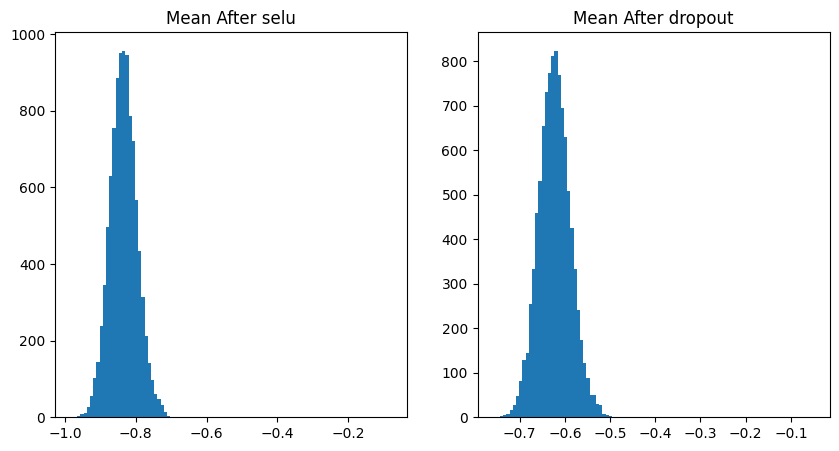

In [1057]:
# plot after selu after dropout
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(after_selu,100)
plt.title("Mean After selu")
plt.subplot(1,2,2)
plt.hist(after_dropout,100)
plt.title("Mean After dropout")
plt.show()

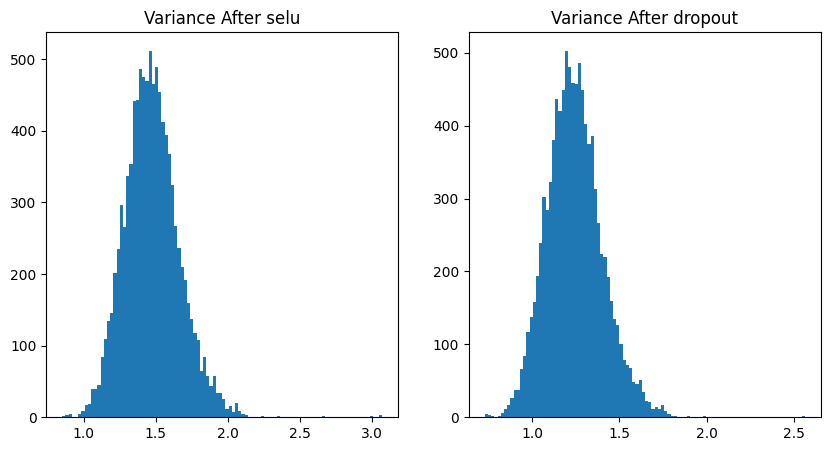

In [1058]:
# plot after selu after dropout
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(after_selu_v,100)
plt.title("Variance After selu")
plt.subplot(1,2,2)
plt.hist(after_dropout_v,100)
plt.title("Variance After dropout")
plt.show()

In [1059]:
peak_mean_selu=(sum(after_selu)/len(after_selu))
peak_mean_dropout=(sum(after_dropout)/len(after_dropout))
peak_var_selu=(sum(after_selu_v)/len(after_selu_v))
peak_var_dropout=(sum(after_dropout_v)/len(after_dropout_v))

Text(0.5, 1.0, 'Mean After dropout')

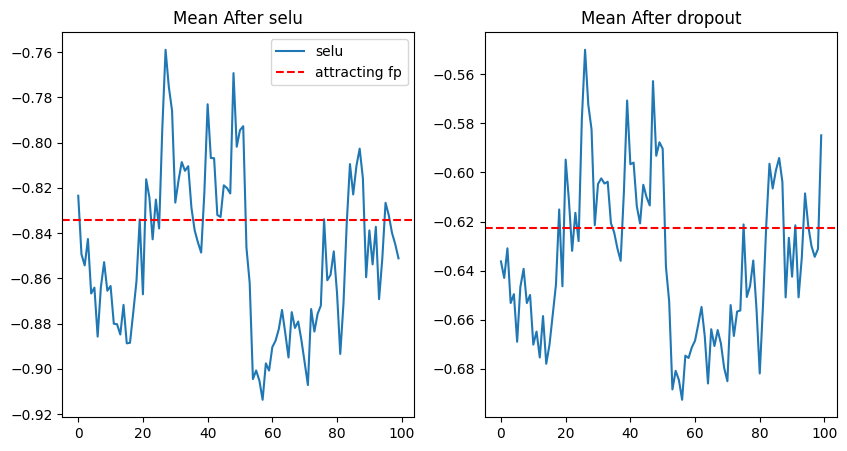

In [1060]:
# plot the mean of the last 100 values of the mean/variance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(after_selu[-100:],label="selu")
plt.axhline(y=peak_mean_selu, color='r', linestyle='--', label="attracting fp")
plt.legend()
plt.title("Mean After selu")
plt.subplot(1,2,2)
plt.plot(after_dropout[-100:])
plt.axhline(y=peak_mean_dropout, color='r', linestyle='--', label="attracting fp")
plt.title("Mean After dropout")

Text(0.5, 1.0, 'Variance After dropout')

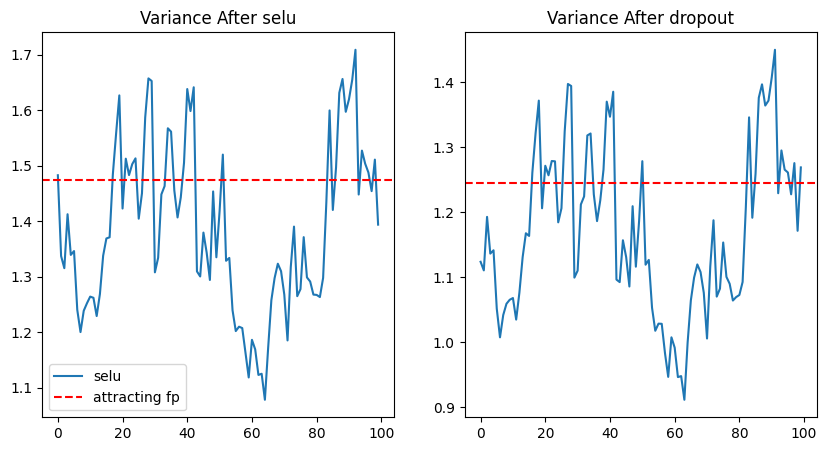

In [1061]:
# plot the mean of the last 100 values of the mean/variance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(after_selu_v[-100:],label="selu")
plt.axhline(y=peak_var_selu, color='r', linestyle='--', label="attracting fp")
plt.legend()
plt.title("Variance After selu")
plt.subplot(1,2,2)
plt.plot(after_dropout_v[-100:])
plt.axhline(y=peak_var_dropout, color='r', linestyle='--', label="attracting fp")
plt.title("Variance After dropout")

### For completeness: These are the correct expressions for mean zero and unit variance

In [1062]:
myAlpha = -np.sqrt(2/np.pi) / (np.exp(0.5) * erfc(1/np.sqrt(2))-1 )  
myLambda = (1-np.sqrt(np.exp(1))*erfc(1/np.sqrt(2)))  *  \
            np.sqrt( 2*np.pi/ (2 + np.pi -2*np.sqrt(np.exp(1))*(2+np.pi)*erfc(1/np.sqrt(2)) + \
            np.exp(1)*np.pi*erfc(1/np.sqrt(2))**2 + 2*np.exp(2)*erfc(np.sqrt(2))))

In [1074]:
print("Alpha parameter of the SELU: ", myAlpha)
print("Lambda parameter of the SELU: ", myLambda)

Alpha parameter of the SELU:  1.6732632423543778
Lambda parameter of the SELU:  1.0507009873554807


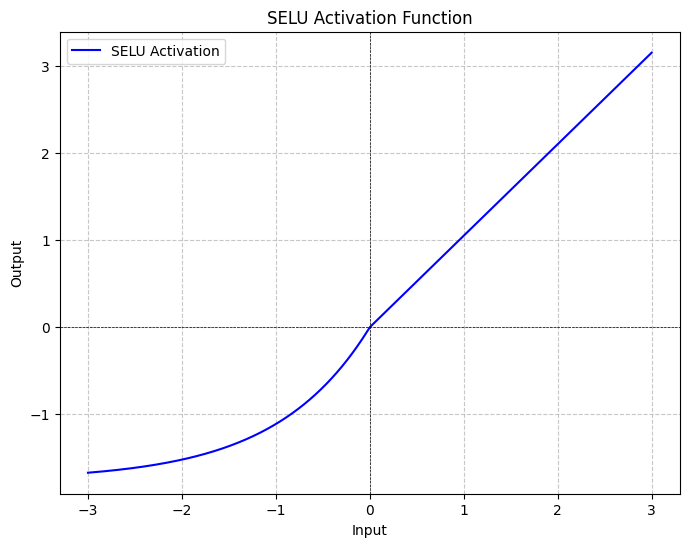

In [1076]:
import numpy as np
import matplotlib.pyplot as plt

def selu(x, alpha=1.67326, lambda_=1.0507):
    """SELU activation function."""
    return lambda_ * np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Generate x values
x_values = np.linspace(-3, 3, 1000)

# Calculate corresponding y values using SELU
y_values = selu(x_values)

# Plot the SELU activation function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='SELU Activation', color='blue')
plt.title('SELU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()
